In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("/home/jovyan/work")

train_data = pd.read_csv('../../data/raw/train.csv')
test_data = pd.read_csv('../../data/raw/test.csv')
print(train_data.shape)
print(test_data.shape)

(8000, 22)
(3799, 21)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)
df_test_scaled = pd.DataFrame(scaler.fit_transform(test_data_x), columns=test_data_x.columns)

X_train, X_val, y_train, y_val = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=8)

print(train_data.shape)
print(X_train.shape)
print(X_val.shape)

(8000, 22)
(6400, 19)
(1600, 19)


In [3]:
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_val_sm, y_val_sm = sm.fit_resample(X_val, y_val)

### Base RF Model

ROC_AUC Score: 0.865
-----------
Confusion Matrix with thresthold of 0.5:
TN: 696, FP: 647
FN: 71, TP: 1272
1919 out of 2686 or 71% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9471
Accuracy: 0.7327
Balanced Accuracy: 0.7327
F1: 0.7799
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.865


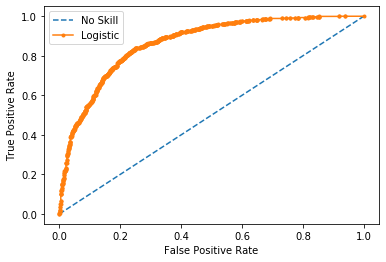

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from src.visualization.visualize import eval_metrics

rfclf = RandomForestClassifier()
rfclf = CalibratedClassifierCV(base_estimator=rfclf, cv=5)
rfclf = rfclf.fit(X_sm, y_sm)
y_pred = rfclf.predict_proba(X_val_sm)[:,1]
eval_metrics(y_pred, y_val_sm, praba_threshold=0.5)

### Hyperot

In [5]:
from hpsklearn import HyperoptEstimator, sgd
from hyperopt import hp

sgd_penalty = 'l2'
sgd_loss = hp.pchoice('loss', [(0.50, 'hinge'), (0.25, 'log'), (0.25, 'huber')])
sgd_alpha = hp.loguniform('alpha', low=np.log(1e-5), high=np.log(1))

estim = HyperoptEstimator(classifier=sgd('my_sgd', penalty=sgd_penalty, loss=sgd_loss, alpha=sgd_alpha))

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [6]:
 estim.fit(X_sm, y_sm)

100%|██████████| 10/10 [00:00<00:00, 193.39trial/s, best loss: 0.25293289535429375]
